Ensure that `ipywidgets` and `ipympl` are installed for interactive widget functionality.

`pip install ipywidgets ipympl`

# Automatic tuning of PID gains with sensitivity constraints

This notebook presents an interactive widget to explore manual tuning of PID gains and the automated solution provided by Collimator.

## Plant

We consider a plant [1] whose dynamics are described by the following third order transfer function:
$$ P(s) = \frac{1}{(2s + 1)^2 (0.5s + 1)} = \frac{1}{2s^3 + 6s^2 + 4.5s + 1} $$

## PID tuning problem
The goal is to find optimal PID controller gains so that the plant closely tracks a reference signal $y_r(t)$, which is considered here as a step function $y_r(t)=1.0$ for $t>0$. A schematic of the closed loop configuration is shown below

<img src="../media/PID_tuning_freq_constraints_schematic.png" alt="PID control schematic" style="width: 600px;"/>

*Figure 1. Closed loop system for the plant controlled by a PID controller*

### Objective
As PID gains are changed---either through an algorithm or manually---the following two metrics are generally used to quantify the efficacy of the chosen PID gains:

\begin{align}
\mathrm{IE}  = \int_0^T e(t) \,dt &\qquad \text{(Integrated Error)},\\[10pt]
\mathrm{IAE} = \int_0^T |e(t)| \, dt &\qquad \text{(Integrated Absolute Error)},
\end{align}

where the simulation time-span is $t\in[0,T]$ and the error $e(t)$ measures the discrepancy between the desired reference $y_r(t)$ and the plant output $y(t)$:

$$ e(t) = y_r(t) - y(t).$$

The unconstrained PID tuning problem thus consists of searching for the PID gains such that a chosen metric (either IE or IAE) is minimized.

### Constraints

To ensure the stability and robustness of the PID-controlled system, it is essential to also consider constraints in the frequency domain. Two important metrics in this regard are the Maximum Sensitivity ($M_s$) and the Maximum Complementary Sensitivity ($M_t$).

#### Maximum Sensitivity (Ms)

The Sensitivity function $S(s)$ measures the sensitivity of the closed loop system to changes in the plant $P(s)$. It is defined as:

$$ S(s) = \frac{1}{1 + P(s)C(s)}, $$

where $ C(s) $ represents the transfer function of the PID controller. The Maximum Sensitivity $ M_s $ is a peak value of $ |S(j\omega)| $ over all frequencies and represents the worst-case amplification of input disturbances in the system. Keeping $ M_s $ low is crucial as it bounds the system's sensitivity to model uncertainties and external disturbances. Typically, a value of $ M_s \leq 2 $ is desired to ensure good robustness.

#### Maximum Complementary Sensitivity (Mt)

The Complementary Sensitivity function $ T(s) $ is defined as:

$$ T(s) = \frac{P(s)C(s)}{1 + P(s)C(s)} $$

It quantifies how much the output $ y(t) $ follows the reference signal $ y_r(t) $ in the presence of noise. The Maximum Complementary Sensitivity $ M_t $ is the peak value of $ |T(j\omega)| $ over all frequencies. This metric is crucial as it bounds the worst-case amplification of sensor noise within the system. To limit noise impact, typically $ M_t $ should be kept below a threshold, often $ M_t \leq 2 $.

### Balancing Sensitivity and Complementary Sensitivity

A fundamental trade-off exists between $ M_s $ and $ M_t $. Lowering $ M_s $ typically results in an increase in $ M_t $, and vice versa. This trade-off needs to be managed carefully during the PID tuning process to achieve a balance between robustness (low $ M_s $) and responsiveness (low $ M_t $).

Keeping the above in mind, the PID tuning problem can be formalized as a constrained optimization problem where the objective is to minimize the error metric (IAE or IE) while satisfying the constraints on the maximum sensitivity and complementary sensitivity. Mathematically, this can be expressed as follows when choosing IAE:

\begin{align}
\text{minimize} \quad J &= \int_0^T |e(t)| \, dt \\[10pt]
\text{subject to} \quad M_s &\leq {M_s^\text{max}}\\[5pt]
\quad M_t &\leq {M_t^\text{max}}\\[10pt]
\text{where}  \quad M_s &=  \text{max}_{\omega}\, |S(j\omega)| \\[5pt]
M_t &=  \text{max}_{\omega}\, |T(j\omega)|
\end{align}

where:
- $J$ is the objective function representing the Integrated Error (IE) or Integrated Absolute Error (IAE).
- $M_s$ and $M_t$ are the maximum sensitivity and maximum complementary sensitivity, respectively, with predefined thresholds ${M_s^\text{max}}$ and ${M_t^\text{max}}$, respectively, that should not be exceeded to ensure robustness against disturbances and noise.

We refer to [2, 3] for further details.

In what follows, we will first create the closed loop plant and attempt to manually and interactively tune the PID gains. Subsequently, we will present the automated tuning solution in Collimator.

We start by importing the relevant libraries.

In [1]:
# For inteactive widget and plotting
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets

import jax
import jax.numpy as jnp

import collimator
from collimator.library import PID, Adder, Step, Integrator, Abs, TransferFunction
from collimator.simulation import Simulator, SimulatorOptions

# python control systems library for computing frequency response
import control as ct

# Only display error logs
from collimator import logging
logging.set_log_level(logging.ERROR)

Next, we define a function to create the closed loop system shown in Figure 1, while also adding components to compute the metric (IAE or IE; $J$ in the optimization problem) to be minimized. A schematic of this configuration is shown below

<img src="../media/PID_tuning_freq_constraints_schematic_with_cost.png" alt="PID control schematic" style="width: 600px;"/>


In [2]:
def make_closed_loop_pid_system(
    plant_tf_num, plant_tf_den, metric="IAE", kp=0.1, ki=0.1, kd=0.1, n=100
):
    builder = collimator.DiagramBuilder()

    pid = builder.add(PID(kp=kp, ki=ki, kd=kd, n=n, initial_state=0.0, name="pid"))
    plant = builder.add(TransferFunction(plant_tf_num, plant_tf_den))

    err = builder.add(Adder(2, operators="+-", name="error"))
    ref = builder.add(Step(0.0, 1.0, 0.0, name="reference"))

    builder.connect(ref.output_ports[0], err.input_ports[0])
    builder.connect(plant.output_ports[0], err.input_ports[1])

    builder.connect(err.output_ports[0], pid.input_ports[0])
    builder.connect(pid.output_ports[0], plant.input_ports[0])

    integrator = builder.add(Integrator(initial_state=0.0, name="integrator"))
    if metric == "IAE":
        abs = builder.add(Abs(name="abs_err"))
        builder.connect(err.output_ports[0], abs.input_ports[0])
        builder.connect(abs.output_ports[0], integrator.input_ports[0])
    elif metric == "IE":
        builder.connect(err.output_ports[0], integrator.input_ports[0])
    else:
        raise ValueError("Invalid metric")

    builder.export_output(plant.output_ports[0], name="plant_output")
    diagram = builder.build(name="closed_loop_system")
    return plant, diagram

Next, we can create the diagram corresponding to our closed loop system and create a `base_context` for this diagram, corresponding to the default PID gains of $k_p = k_i = k_d = 0.1$. Later we will modify this `base_context` to vary the values of the PID gains. We also define the thresholds for the maximum sensitivity constraints and the range of frequencies over which to evaluate the constraints.

In [3]:
metric = "IAE"

plant_tf_num = [1.0]
plant_tf_den = [2.0, 6.0, 4.5, 1.0]

plant, diagram = make_closed_loop_pid_system(plant_tf_num, plant_tf_den, metric=metric)
base_context = diagram.create_context()

Ms_max = 1.2 # Ms max threshold
Mt_max = 1.2 # Mt max threshold

omega = 10.0 ** jnp.linspace(-2, 2, 200)

# Python control systems library object for the Plant transfer function
Ps = ct.TransferFunction(plant_tf_num, plant_tf_den, name="Plant")

Next we create the Collimator simulator object, and compile its `advance_to` method so that the interactive widget runs and displays the results of the simulations quickly as we vary the PID gains.

In [4]:
recorded_signals = {
    "objective": diagram["integrator"].output_ports[0],
    "reference": diagram["reference"].output_ports[0],
    "plant": diagram.output_ports[0],
    "pid": diagram["pid"].output_ports[0],
}

options = SimulatorOptions(save_time_series=True, recorded_signals=recorded_signals)
simulator = Simulator(diagram, options=options)
advance_to = jax.jit(simulator.advance_to)

With the above in place, we can now create two functions: the first runs the simulation in the time domain with a set of PID gains, and the second evaluates the sensitivities $S$ and $T$ over a range of $\omega$.

In [5]:
def run_sim(kp, ki, kd, diagram, base_context, sim_time=10.0):
    pid_system_id = diagram["pid"].system_id
    pid_subcontext = base_context[pid_system_id].with_parameters({"kp": kp, "ki": ki, "kd":kd})
    context = base_context.with_subcontext(pid_system_id, pid_subcontext)

    results = advance_to(sim_time, context)

    t, outputs = results.results_data.finalize()
    
    return t, outputs

def get_sensitivities(kp, ki, kd):
    Cs = ct.TransferFunction([kd, kp, ki], [1, 0], name="PID") # transfer function for PID controller
    
    S = 1/(1+Ps*Cs)
    T = Ps*Cs/(1+Ps*Cs)
    
    mag_S, phase_S, omega_S = S.frequency_response(omega)
    mag_T, phase_T, omega_T = T.frequency_response(omega)

    return mag_S, mag_T

Finally, we can now create an interactive widget to manually vary the PID gains and observe both the time-domain and frequency-domain responses interactively. In the widget, try to manually vary the gains to minimize the metric $J$ without violating constraints. You will find that this is not an easy problem.

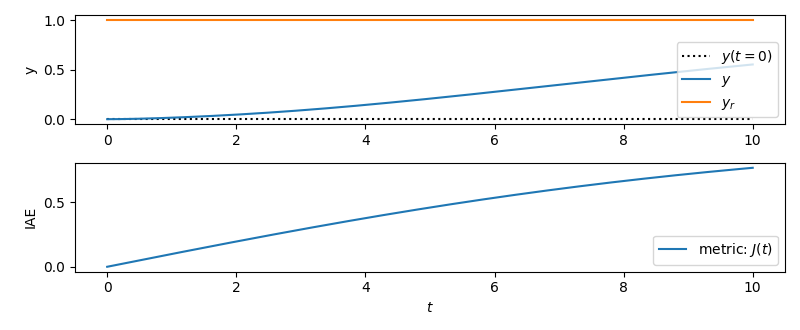

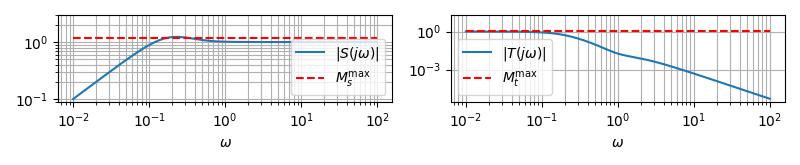

In [6]:
# Fig size, adjust according to your screen
width = 8.0
height = 3.3

# Initialize the figure and axes
# fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(width, height))
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, height))

# Initial values
kp = 0.1
ki = 0.1
kd = 0.1
sim_time = 10.0

# Run initial simulation
time, outputs = run_sim(kp, ki, kd, diagram, base_context, sim_time)

# Get initial frequency response
mag_S, mag_T = get_sensitivities(kp, ki, kd)

# Plot initial data
# Plot time response
line0, = ax1.plot(time, 0.0*time, 'k:', label=r"$y(t=0)$")
line1, = ax1.plot(time, outputs["plant"], label=r"$y$")
line2, = ax1.plot(time, outputs["reference"], label=r"$y_r$")
line3, = ax2.plot(time, outputs["objective"]/sim_time, label="metric: $J(t)$")

ax2.set_xlabel("$t$")

ax1.legend(loc="lower right")
ax2.legend(loc="lower right")

ax1.set_ylabel("y")
ax2.set_ylabel(metric)

# Plot frequency response
fig2, (ax4, ax5) = plt.subplots(1, 2, figsize=(width, height/2))
line4, = ax4.loglog(omega, mag_S, label="$|S(j\omega)|$")
line5, = ax5.loglog(omega, mag_T, label="$|T(j\omega)|$")

ax4.set_ylim(None, 3)
ax5.set_ylim(None, 20)

ax4.set_xlabel("$\omega$")
ax5.set_xlabel("$\omega$")

ax4.hlines(Ms_max, 0.01, 100.0, colors='r', linestyles="--", label=r"${M_s^\text{max}}$")
ax5.hlines(Mt_max, 0.01, 100.0, colors='r', linestyles="--", label=r"${M_t^\text{max}}$")

ax4.grid(which="both"); ax4.legend(loc="lower right")
ax5.grid(which="both"); ax5.legend(loc="lower left")

for fig in (fig1, fig2):
    fig.tight_layout()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False


def update_plot(kp, ki, kd):
    # Update time response
    # Run simulation with new parameters
    time, outputs = run_sim(kp, ki, kd, diagram, base_context, sim_time)
    mag_S, mag_T = get_sensitivities(kp, ki, kd)
    
    # Update the lables for J and constraints violation
    objective_label.value = f"J = {outputs['objective'][-1]/sim_time:0.3f}"
    constraint_Ms_label.value = f"$M_s\,$ constraint satisfied: {jnp.max(mag_S)<=Ms_max}"
    constraint_Mt_label.value = f"$M_t\,$ constraint satisfied: {jnp.max(mag_S)<=Mt_max}"
    
    # Update time reponse plot 
    line1.set_data(time, outputs["plant"])
    line2.set_data(time, outputs["reference"])
    line3.set_data(time, outputs["objective"]/sim_time)
    # line4.set_xdata(time, outputs["pid"])

    # Adjust the axis limits
    for ax in (ax1, ax2):
        ax.relim()
        ax.autoscale_view()
        
    # Redraw the figure
    fig1.canvas.draw_idle()

    # Update Frequency response plot
    line4.set_ydata(mag_S)
    line5.set_ydata(mag_T)
    
    # Redraw the figure
    fig2.canvas.draw_idle()

full_width_layout = widgets.Layout(width=f'{width*96}px')
kp_slider = widgets.FloatSlider(value=0.1, min=0.0, max=100.0, step=0.1, description="$k_p$", layout=full_width_layout)
ki_slider = widgets.FloatSlider(value=0.1, min=0.0, max=100.0, step=0.1, description="$k_i$", layout=full_width_layout)
kd_slider = widgets.FloatSlider(value=0.1, min=0.0, max=100.0, step=0.1, description="$k_d$", layout=full_width_layout)

# label_layout = widgets.Layout(flex='1 1 auto', width='auto')
label_layout = widgets.Layout(display='flex', align_items='center', justify_content='center', width=f'{width*96}px')
info_label = widgets.Label(value="Vary $\,k_p, k_i, k_d\,$ to minimize $\,J\,$ (make plant output best follow reference) without violating constraints", layout=label_layout, style={'font_size': '16px'})
objective_label = widgets.Label(value=f"J = {outputs['objective'][-1]/sim_time:0.3f}", layout=label_layout)
constraint_Ms_label = widgets.Label(value=f"$M_s\,$ constraint satisfied: {jnp.max(mag_S)<=Ms_max}", layout=label_layout)
constraint_Mt_label = widgets.Label(value=f"$M_t\,$ constraint satisfied: {jnp.max(mag_T)<=Mt_max}", layout=label_layout)


# Link sliders to update function
def on_value_change(change):
    update_plot(kp_slider.value, ki_slider.value, kd_slider.value)

kp_slider.observe(on_value_change, names='value')
ki_slider.observe(on_value_change, names='value')
kd_slider.observe(on_value_change, names='value')

# Display sliders and initial plot
sliders = [kp_slider, ki_slider, kd_slider]
labels = [objective_label, constraint_Ms_label, constraint_Mt_label]
widgets.VBox([info_label, *sliders, *labels])

## Automatic tuning in Collimator

Collimator provides an easy-to-use AutoTuner for solving the above constrained optimization problem. Its usage is shown below.

In [7]:
from collimator.optimization import AutoTuner

params_0 = jnp.array([0.1, 0.1, 0.1])

tuner = AutoTuner(
    plant,
    n=100, # derivative filter coefficient for PID
    sim_time=sim_time,
    metric=metric,
    pid_gains_0=params_0,
    Ms=Ms_max,
    Mt=Mt_max,
    pid_gains_upper_bounds=[100.0]*3,
    method="scipy-slsqp",
)

opt_params, res = tuner.tune()
print(f"Optimal PID gains: {res.x}")

Tuning with scipy-slsqp
Optimal PID gains: [2.96609151 0.81734522 3.7869994 ]


Collimator also includes a simple utility to quickly plot the responses in the time and frequency domains.

objective = 0.13720085988982414


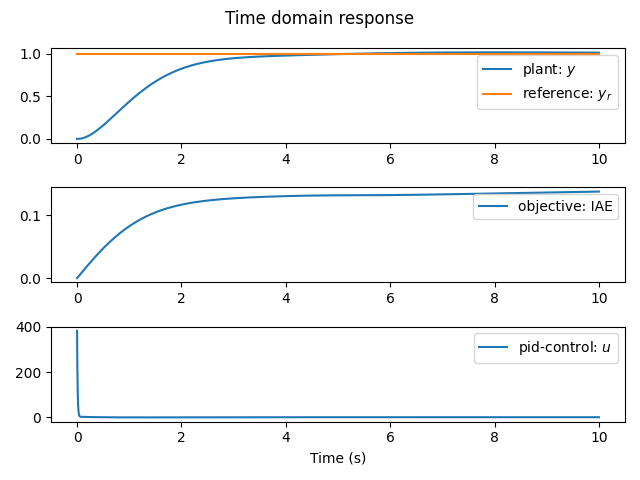

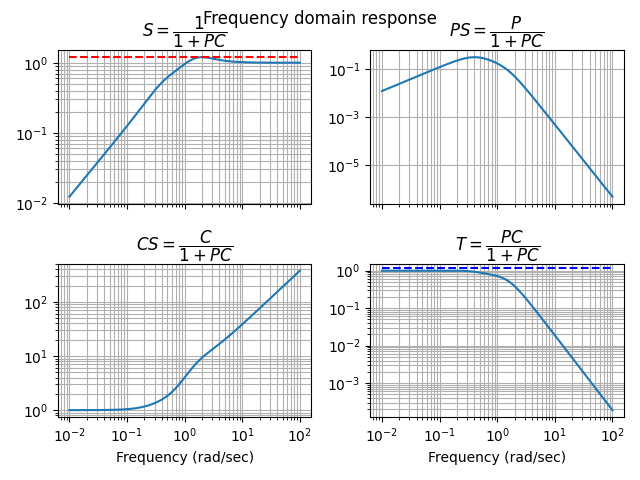

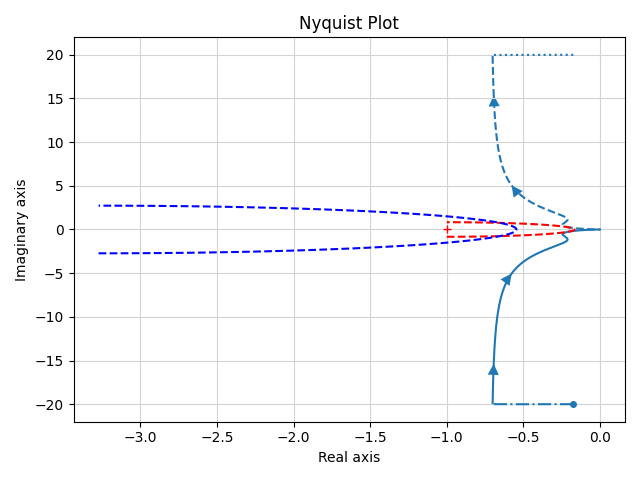

In [8]:
fig_g4, fig_nyq, fig_time = tuner.plot_freq_and_time_responses(
    res.x,
    plant_tf_num,
    plant_tf_den,
)

plt.show()

We find that the AutoTuner quickly finds a good solution, balancing both requirements of minimizing the metric and satisfying the constraints.

## References:

[1] Plant example taken from: https://github.com/JuliaControl/ControlExamples.jl/blob/master/autotuning.ipynb

[2] Hast, M., Åström, K.J., Bernhardsson, B. and Boyd, S., 2013, July.
PID design by convex-concave optimization. In 2013 European Control Conference (ECC)
(pp. 4460-4465). IEEE.

[3] [2] Soltesz, K., Grimholt, C. and Skogestad, S., 2017. Simultaneous design of
proportional–integral–derivative controller and measurement filter by optimisation.
IET Control Theory & Applications, 11(3), pp.341-348.